# CEIA - Visión por computadora 2

Integrantes del equipo:

* a1604 | Federico Arias Suárez | f_ariassuarez@hotmail.com
* a1618 | Myrna Lorena,Degano | myrna.l.degano@gmail.com
* a1620 | Gustavo Julián Rivas | gus.j.rivas@gmail.com


## Conjunto de datos

### Descripción

https://universe.roboflow.com/myworkspace-iraqv/wildfire_full  
<br>
* <u>Tipo de problema a resolver</u>: Detección de objetos.  
<br>
* <u>Objetivo</u>: Detectar focos de incendio.  
<br>
* <u>Motivación</u>: La Amazonía se está quemando a un ritmo alarmante, afectando el clima, la biodiversidad y el calentamiento global.
Detectar incendios de manera temprana podría marcar la diferencia para evitar daños mayores.

* <u>Créditos</u>:  

 - **title**: Wildfire_Full Dataset
 - **type**: Open Source Dataset
 - **author**: MyWorkspace
 - **URL**: https://universe.roboflow.com/myworkspace-iraqv/wildfire_full
 - **published**: Roboflow Universe
 - **publisher**: Roboflow
 - **year**: 2024
 - **month**: oct

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import os, shutil, random, yaml, json, math, torch, argparse, glob, gdown, zipfile

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from tqdm import tqdm
from roboflow import Roboflow
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from PIL import Image, ImageDraw, ImageFont
from collections import Counter, defaultdict
from pathlib import Path


In [ ]:
# Download desde Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)

loading Roboflow workspace...
loading Roboflow project...


### Descarga

In [ ]:
def printREADME(readme_file_name, download_path, files_in_directory):
  """
  Función para imprimir los datos del README del dataset
  """

  readme_path = os.path.join(download_path, readme_file_name)

  if readme_file_name in files_in_directory:
    with open(readme_path, 'r') as readme_file:
        readme_content = readme_file.read()

        start_pos = readme_content.find("The dataset includes")

        if start_pos != -1:
            print(readme_content[start_pos:])

In [ ]:
def printFilesFolders(download_path):
  """
  Función para mostrar cómo está estructurado el dataset
  División en train-valid-test y cantidad de archivos
  """
  for dir in ['train', 'valid', 'test']:

    full_path = download_path + '/'  + dir + '/'

    print('\n\n-----')
    print(dir)
    print('-----')

    files = [f for f in Path(full_path).rglob('*') if f.is_file()]
    subdirectories = [f for f in Path(full_path).iterdir() if f.is_dir()]

    for subdir in subdirectories:
      print(f' - {subdir.name}')

    # Crear un defaultdict para contar las extensiones de archivo
    file_types_count = defaultdict(int)

    # Contar las ocurrencias de cada extensión en los archivos
    for f in files:
        _, extension = os.path.splitext(f)
        # Convertir la extensión a minúsculas
        extension = extension.lower()  # Convertir la extensión a minúsculas

        # Incrementar el contador para esa extensión
        file_types_count[extension] += 1

    # Imprimir las extensiones y sus cantidades para este directorio
    for ext, count in file_types_count.items():
        print(f"{count} archivos de extensión {ext}")


Se utiliza el dataset con anotaciones en formato COCO:

In [ ]:
format = 'coco'

In [ ]:
dataset_name = 'Wildfire_Full-1'
root_path = '/content/'
download_path = root_path + dataset_name

In [ ]:
# Download del conjunto de datos publicado en formato COCO
dataset = version.download(format)


Extracting Dataset Version Zip to Wildfire_Full-1 in coco:: 100%|██████████| 896/896 [00:00<00:00, 2219.23it/s]


In [ ]:
files_in_directory = os.listdir(download_path)

In [ ]:
printREADME('README.roboflow.txt', download_path, files_in_directory)

The dataset includes 888 images.
Fire are annotated in COCO format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.





In [ ]:
printFilesFolders(download_path)



-----
train
-----
622 archivos de extensión .jpg
1 archivos de extensión .json


-----
valid
-----
177 archivos de extensión .jpg
1 archivos de extensión .json


-----
test
-----
89 archivos de extensión .jpg
1 archivos de extensión .json


In [ ]:
new_dataset_name = dataset_name + '_' + format

dataset_path_coco = root_path + new_dataset_name

!mv "{download_path}" "{dataset_path_coco}"

In [ ]:
# Corregir definiciones de clases (sólo 2 -> Fire/Smoke)
for step in ['train', 'valid', 'test']:

  print(f'\n{step}:')
  # Cargar el archivo JSON de anotaciones
  annotations_file = f'{dataset_path_coco}/{step}/_annotations.coco.json'

  with open(annotations_file, 'r') as f:
      data = json.load(f)

  print(data['categories'])

  # Eliminar la categoría con id 0
  data['categories'] = [category for category in data['categories'] if category['id'] != 0]

  # Reindexar las categorías para que empiecen desde 1
  category_id_map = {category['id']: idx + 1 for idx, category in enumerate(data['categories'])}
  for category in data['categories']:
      category['id'] = category_id_map[category['id']]

  # Verificar las categorías después de la modificación
  print("Categorias después de eliminación y reindexación:")
  print(data['categories'])

  # Guardar el archivo JSON corregido
  with open(annotations_file, 'w') as f:
    json.dump(data, f)



train:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]

valid:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]

test:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]


In [ ]:
classes_list = []

for category in data['categories']:

  classes_list.append(category['name'])

print(classes_list)


['Fire', 'Smoke']


## Modelo a evaluar

### Detectron 2 (RetinaNet)

https://github.com/facebookresearch/detectron2


Detectron2 es una biblioteca de código abierto desarrollada por Facebook AI Research (FAIR), diseñada para realizar tareas de visión por computadora utilizando modelos de aprendizaje profundo.

Detectron2 se basa en el uso de redes neuronales convolucionales (CNNs) para analizar imágenes y detectar patrones.


#### Set up

In [ ]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  2.5 ; cuda:  cu121


In [ ]:
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5ijgj4zw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5ijgj4zw
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.3 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

In [ ]:
import detectron2
import logging

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo

from detectron2.config import get_cfg

from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, build_detection_test_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import *
from detectron2.data import detection_utils as utils

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor

from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils import registry

from detectron2.structures import BoxMode

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

from detectron2.data import transforms as T
from detectron2.data.detection_utils import read_image


In [ ]:
# Instancia de Configuración del modelo
cfg = get_cfg()

In [ ]:
# Crear el directorio de salida donde se guardarán los modelos entrenados y otros archivos relacionados.
cfg.OUTPUT_DIR = "detectron2-output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
setup_logger()

<Logger detectron2 (DEBUG)>

#### Registrar datasets

Detectron2 necesita saber cómo leer y manejar el conjunto de datos antes de poder usarlo para el entrenamiento o la inferencia.   Por lo tanto, se deben registrar los conjuntos de datos COCO con la siguiente instrucción:

In [ ]:
register_coco_instances("coco_dataset_train", {}, dataset_path_coco + "/train/_annotations.coco.json", dataset_path_coco + "/train")
register_coco_instances("coco_dataset_valid", {}, dataset_path_coco + "/valid/_annotations.coco.json", dataset_path_coco + "/valid")
register_coco_instances("coco_dataset_test", {}, dataset_path_coco + "/test/_annotations.coco.json", dataset_path_coco + "/test")

* Register_coco_instances:  
  * Crea un registro del conjunto de datos.  
  * Conecta las anotaciones COCO con las imágenes.  
  * Permite que Detectron2 acceda a los datos.

* MetadataCatalog:   
obtiene los metadatos asociados con el conjunto de datos registrado.  Los metadatos pueden incluir información sobre el conjunto de datos, como:
 - Categorías de objetos: Los nombres de las clases que contiene el conjunto de datos.
 - Color de las etiquetas: Los colores utilizados para representar diferentes categorías de objetos en las visualizaciones.
 - Otras configuraciones personalizadas: Información adicional que puede ser relevante para la visualización o el análisis del conjunto de datos.

* DatasetCatalog:   
obtiene el registro de las instancias del conjunto de datos. Es decir, devuelve las anotaciones del conjunto de datos para que puedan ser usadas para el entrenamiento o la evaluación.  
El conjunto de datos es representado como una lista de diccionarios, donde cada diccionario describe una imagen y sus anotaciones asociadas (por ejemplo, las categorías de los objetos en esa imagen, las posiciones de los cuadros delimitadores, etc.).

In [ ]:
dataset_train_metadata = MetadataCatalog.get("coco_dataset_train")
dataset_train_dicts = DatasetCatalog.get("coco_dataset_train")

[12/06 14:58:07 d2.data.datasets.coco]: Loaded 622 images in COCO format from /content/Wildfire_Full-1_coco/train/_annotations.coco.json


#### Visualización

Visualizar ejemplos del set de entrenamiento (imagen + bb)

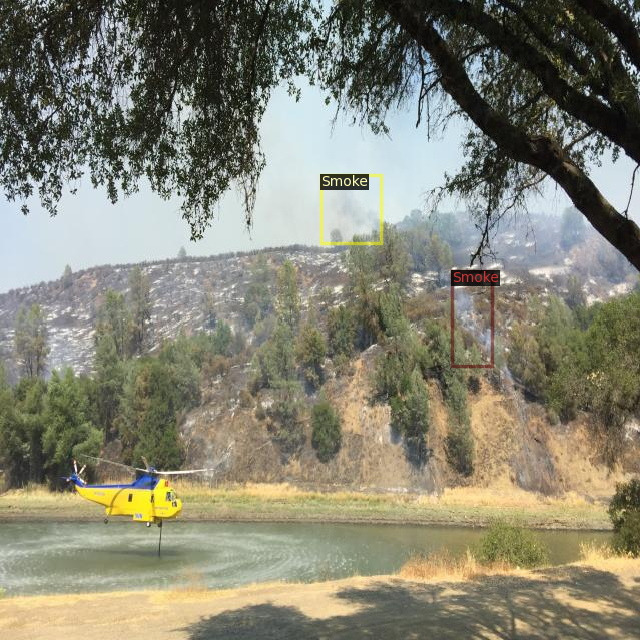

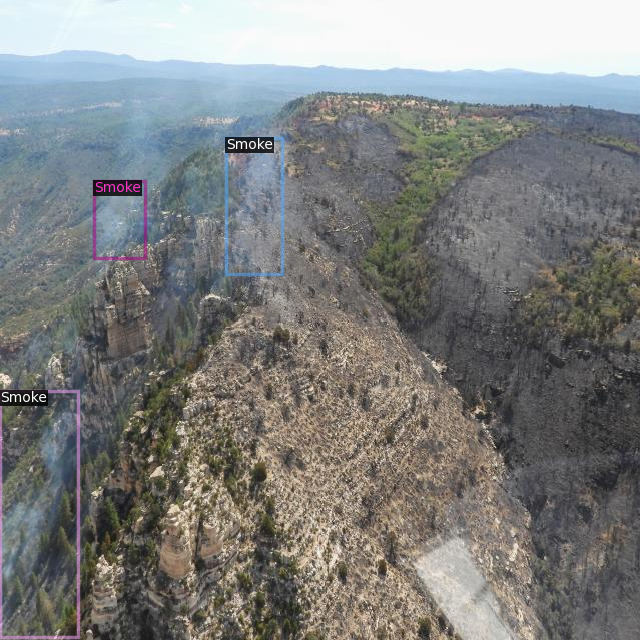

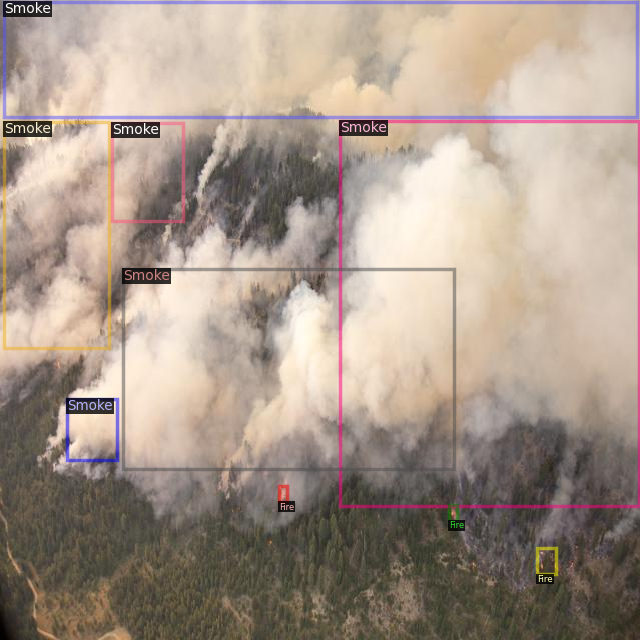

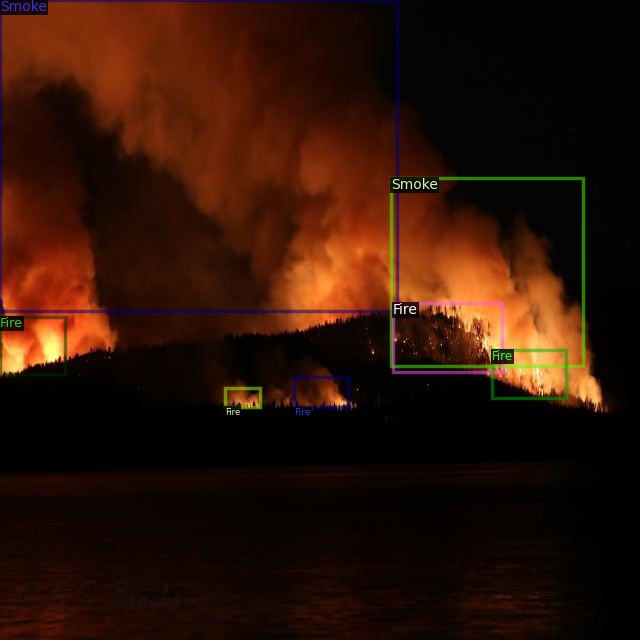

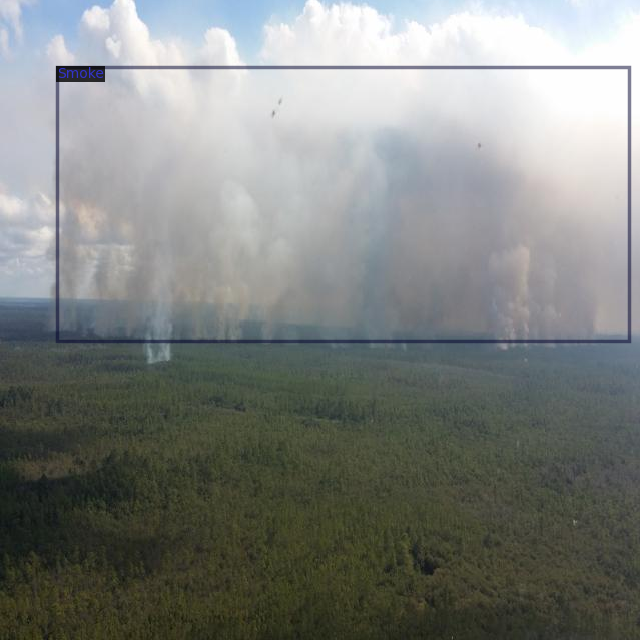

In [ ]:
#Visualizar

n_sample = 5

for d in random.sample(dataset_train_dicts, n_sample):
    print()
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_train_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

#### Configuración

Obtener un modelo que ya está preentrenado en COCO y se puede usar como punto de partida para tareas de detección de objetos.  En este caso, retinanet:

In [ ]:
model = "COCO-Detection/retinanet_R_50_FPN_1x.yaml"

# Cargar la configuración preentrenada desde el modelo en el modelo_zoo de Detectron2
cfg.merge_from_file(model_zoo.get_config_file(model))

Configuración:

* **Retinanet**  
Arquitectura de red neuronal profunda para la detección de objetos, que fue propuesta para resolver problemas de desbalance de clases en detección. Es muy eficiente para detectar objetos en diversas escalas y es conocida por su capacidad para manejar bien la localización de objetos pequeños y grandes.
RetinaNet utiliza una red neuronal convolucional (CNN) como su backbone y emplea una función de pérdida Focal Loss, que mejora la precisión en tareas con un gran desbalance entre clases (por ejemplo, cuando algunos objetos son mucho más frecuentes que otros).

* **R_50**  
La letra R hace referencia al ResNet (Residual Network), que es la red neuronal profunda que se utiliza como base o "backbone" para el modelo de detección. ResNet es muy popular por su capacidad de entrenar redes muy profundas de manera efectiva, gracias a sus conexiones residuales (que ayudan a resolver problemas de desvanecimiento del gradiente en redes profundas).  
50 se refiere a que este modelo está utilizando ResNet-50 como backbone, lo que significa que la red tiene 50 capas.

* **FPN**  
Feature Pyramid Network, una técnica que se utiliza para mejorar la detección de objetos en diversas escalas. En términos simples, la FPN permite que el modelo combine características de diferentes niveles de resolución de la red para mejorar la precisión de la detección de objetos pequeños y grandes.
Usar una Feature Pyramid Network es particularmente útil para detectar objetos que pueden tener tamaños muy diferentes en las imágenes.

* **1x**  
1x se refiere al número de iteraciones de entrenamiento del modelo. Especifica que el modelo ha sido entrenado con 270,000 iteraciones (la cantidad de veces que el modelo pasa por todo el conjunto de datos durante el entrenamiento).

In [ ]:
# Conjuntos de datos
cfg.DATASETS.TRAIN = ("coco_dataset_train", )
cfg.DATASETS.TEST = ("coco_dataset_valid", )

# Número de procesos de trabajo para cargar datos de manera concurrente.
cfg.DATALOADER.NUM_WORKERS = 2

# Especificar pesos preentrenados como punto de partida
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
# Ajustar al número de clases del conjunto de datos
cfg.MODEL.RETINANET.NUM_CLASSES = 2

In [ ]:
# Parámetros de entrenamiento
#--------------------------------

cfg.SOLVER.IMS_PER_BATCH = 4 # Número de imágenes por lote (batch size).

n_epochs = 50 # Cantidad de épocas

cfg.SOLVER.BASE_LR = 0.001 # Tasa de aprendizaje inicial (learning rate).

cfg.SOLVER.MAX_ITER = (len(dataset_train_dicts)//cfg.SOLVER.IMS_PER_BATCH)*n_epochs # Número máximo de iteraciones (pasos) de entrenamiento.


In [ ]:
# Mostrar todos los parámetros del optimizador
print(cfg.SOLVER.dump())

AMP:
  ENABLED: false
BASE_LR: 0.001
BASE_LR_END: 0.0
BIAS_LR_FACTOR: 1.0
CHECKPOINT_PERIOD: 5000
CLIP_GRADIENTS:
  CLIP_TYPE: value
  CLIP_VALUE: 1.0
  ENABLED: false
  NORM_TYPE: 2.0
GAMMA: 0.1
IMS_PER_BATCH: 4
LR_SCHEDULER_NAME: WarmupMultiStepLR
MAX_ITER: 7750
MOMENTUM: 0.9
NESTEROV: false
NUM_DECAYS: 3
REFERENCE_WORLD_SIZE: 0
RESCALE_INTERVAL: false
STEPS:
- 60000
- 80000
WARMUP_FACTOR: 0.001
WARMUP_ITERS: 1000
WARMUP_METHOD: linear
WEIGHT_DECAY: 0.0001
WEIGHT_DECAY_BIAS: null
WEIGHT_DECAY_NORM: 0.0



Por default, se utiliza un planificador *WarmupMultiStepLR*, que realiza un calentamiento de la tasa de aprendizaje al principio del entrenamiento y luego reduce la tasa de aprendizaje en pasos múltiples.

In [ ]:
# Parámetros para evaluación
#--------------------------------
cfg.TENSORBOARD = True

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5 # Umbral de confianza de la detección

cfg.TEST.EVAL_PERIOD = 500 # Cada cuántas iteraciones chequear métricas de validación


In [ ]:
# Mostrar todos los parámetros del modelo
print(cfg.MODEL.dump())

ANCHOR_GENERATOR:
  ANGLES:
  - - -90
    - 0
    - 90
  ASPECT_RATIOS:
  - - 0.5
    - 1.0
    - 2.0
  NAME: DefaultAnchorGenerator
  OFFSET: 0.0
  SIZES:
  - - 32
    - 40.31747359663594
    - 50.79683366298238
  - - 64
    - 80.63494719327188
    - 101.59366732596476
  - - 128
    - 161.26989438654377
    - 203.18733465192952
  - - 256
    - 322.53978877308754
    - 406.37466930385904
  - - 512
    - 645.0795775461751
    - 812.7493386077181
BACKBONE:
  FREEZE_AT: 2
  NAME: build_retinanet_resnet_fpn_backbone
DEVICE: cuda
FPN:
  FUSE_TYPE: sum
  IN_FEATURES:
  - res3
  - res4
  - res5
  NORM: ''
  OUT_CHANNELS: 256
KEYPOINT_ON: false
LOAD_PROPOSALS: false
MASK_ON: false
META_ARCHITECTURE: RetinaNet
PANOPTIC_FPN:
  COMBINE:
    ENABLED: true
    INSTANCES_CONFIDENCE_THRESH: 0.5
    OVERLAP_THRESH: 0.5
    STUFF_AREA_LIMIT: 4096
  INSTANCE_LOSS_WEIGHT: 1.0
PIXEL_MEAN:
- 103.53
- 116.28
- 123.675
PIXEL_STD:
- 1.0
- 1.0
- 1.0
PROPOSAL_GENERATOR:
  MIN_SIZE: 0
  NAME: RPN
RESNETS:
  DEFO

La principal preocupación en la detección de incendios es identificar la ubicación exacta del fuego para poder tomar medidas preventivas o de emergencia, como activar sistemas de rociadores, alertar a los bomberos, o iniciar procedimientos de evacuación.   

Sin una localización precisa, las acciones de respuesta pueden ser ineficaces, incluso si el modelo clasifica correctamente la presencia de fuego.  

Aunque la clasificación es también importante para este problema en particular, decidimos poner más énfasis en la localización, ya que, si el modelo confunde "humo" con "fuego", pero el área está bien localizada, aún es posible aplicar medidas de mitigación.  
Sin embargo, si la localización es incorrecta, entonces el modelo no será útil, incluso si la clasificación es correcta.

In [ ]:
if torch.cuda.is_available():
    cfg.MODEL.DEVICE = "cuda"  # Usar GPU si está disponible
else:
    cfg.MODEL.DEVICE = "cpu"   # Usar CPU si no hay GPU disponible

cfg.MODEL.DEVICE

'cuda'

#### Transformaciones aplicadas a las imágenes

https://detectron2.readthedocs.io/en/latest/modules/data_transforms.html

Para un dataset que tiene como objetivo la detección de fuego y humo, es importante considerar las características visuales de estos fenómenos y cómo pueden variar según las condiciones de iluminación, el entorno, la distancia y las condiciones meteorológicas.   

Es por esto que exploramos las siguientes transformaciones:

1 - **Cambio de brillo y contraste:**  
El fuego y el humo pueden variar mucho en brillo y contraste dependiendo de la luz ambiental. Si la imagen es tomada durante el día o la noche, o si la imagen tiene una fuente de luz cerca, el brillo y el contraste de la imagen pueden cambiar considerablemente.
Usar transformaciones como RandomBrightness y RandomContrast es muy útil para generalizar el modelo y permitirle detectar fuego y humo en diferentes condiciones de iluminación.  


2 - **Saturación y matiz:**  
El fuego a menudo tiene colores saturados y brillantes (rojos, amarillos, naranjas), mientras que el humo puede variar de gris a blanco. Variar la saturación con RandomSaturation puede ayudar a que el modelo sea más robusto frente a esas variaciones de color.  


3 - **Cambio en la iluminación:**  
Dado que el fuego puede ser visible en diferentes condiciones de luz (por ejemplo, a plena luz del día o en la oscuridad), es importante usar RandomLighting para ayudar al modelo a aprender a detectar fuego y humo independientemente de las variaciones en la iluminación ambiental.  


5 - **Simulación de condiciones meteorológicas**:  
Si hay imágenes que representan fuego y humo en diferentes condiciones meteorológicas (por ejemplo, imágenes con niebla o lluvia), transformaciones como RandomSaturation o RandomBrightness para simular estas condiciones.  

*DefaultTrainer* es la clase proporcionada por Detectron2 que maneja el ciclo completo de entrenamiento para modelos de detección de objetos.   

Decidimos extender esta clase para incluir la evaluación de las métricas sobre el set de evaluación durante el entrenamiento (*build_evaluator*).  

De igual forma, decidimos extender dos clases diferentes, con y sin augmentations, para comparar el desempeño de ambos entrenamientos.


In [ ]:
class CocoTrainer(DefaultTrainer):

  """
  Trainer custom
  * Con evaluación de métricas
  * Sin transformaciones
  """

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)


In [ ]:
class CocoTrainer_wAugs(DefaultTrainer):

  """
  Trainer custom
  * Con evaluación de métricas
  * Con transformaciones
  """

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)


  @classmethod
  def build_train_loader(cls, cfg):

    augmentations = [
                    T.RandomBrightness(0.8, 1.2),  # Cambio aleatorio en el brillo
                    T.RandomContrast(0.8, 1.2),  # Cambio aleatorio en el contraste
                    T.RandomSaturation(0.8, 1.2),  # Cambio aleatorio en la saturación
                    T.RandomLighting(0.2),  # Cambio aleatorio en la iluminación
                    ]

    mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)

    return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
# Función para visualizar imágenes
def visualize_images(original, transformed):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    axes[1].imshow(transformed)
    axes[1].set_title("Imagen Transformada")
    axes[1].axis('off')

    plt.show()

Aplicamos las transformaciones con el DatasetMapper para visualizar el impacto que producen sobre las imágenes originales.

In [ ]:
# Ejemplo de visualización
augsV = [
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.8, 1.2),
        T.RandomSaturation(0.8, 1.2),
        T.RandomLighting(0.2),
        ]

mapperV = DatasetMapper(cfg, is_train=True, augmentations=augsV)


[12/06 14:58:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomContrast(intensity_min=0.8, intensity_max=1.2), RandomSaturation(intensity_min=0.8, intensity_max=1.2), RandomLighting(scale=0.2)]


Cada una de estas funciones corresponde a una transformación aleatoria que modifica el brillo, el contraste, la saturación o la iluminación de la imagen.

1. **T.RandomBrightness**(0.8, 1.2)  
 - Descripción: Esta transformación ajusta el brillo de la imagen aleatoriamente en un rango determinado.
 - Comportamiento: El valor de brillo de la imagen se ajusta multiplicando todos los píxeles por un factor aleatorio entre 0.8 y 1.2.  
 Si el valor es menor que 1 (por ejemplo, 0.9), la imagen se oscurece. Si es mayor que 1 (por ejemplo, 1.1), la imagen se ilumina.  

2. **T.RandomContrast**(0.8, 1.2)  
 - Descripción: Esta transformación ajusta el contraste de la imagen aleatoriamente en un rango determinado.
 - Comportamiento: El contraste de la imagen se ajusta multiplicando la diferencia entre cada píxel y el valor medio de la imagen por un factor aleatorio en el rango 0.8 a 1.2.  
 Si el factor es menor que 1, el contraste se reduce (se hace más "plana" la imagen, con menor diferencia entre los valores de los píxeles).   
 Si es mayor que 1, se aumenta el contraste, haciendo que las diferencias entre los valores de los píxeles sean más notorias.  

3. **T.RandomSaturation**(0.8, 1.2)  
 - Descripción: Esta transformación ajusta la saturación de la imagen, lo que afecta la intensidad de los colores.
 - Comportamiento: La saturación se ajusta multiplicando los valores de los píxeles por un factor aleatorio entre 0.8 y 1.2.  
 Si el valor es menor que 1, la imagen se vuelve más gris (menos saturada), ya que los colores pierden intensidad.   
 Si es mayor que 1, los colores se acentúan y la imagen se vuelve más vibrante.  

4. **T.RandomLighting**(0.2)  
 - Descripción: Esta transformación aplica ajustes en la iluminación de la imagen, específicamente ruido de iluminación.
 - Comportamiento: Se introduce un cambio aleatorio en la iluminación de la imagen aplicando un ruido gaussiano con una desviación estándar del 20% (0.2) de la iluminación de la imagen.  
 Esto hace que los valores de color en la imagen se modifiquen de manera no lineal, creando variaciones en los niveles de iluminación.
<br>
* *Orden aleatorio*: Las transformaciones se aplican de manera aleatoria, pero también en un orden aleatorio. Es decir, por cada imagen, las transformaciones se eligen de manera aleatoria, pero el orden en el que se aplican puede cambiar entre iteraciones.

* *Combinación de efectos*: Debido a que cada transformación modifica la imagen de forma independiente, el modelo verá imágenes modificadas en varios aspectos a través del entrenamiento.   
Por ejemplo, una imagen puede tener brillo reducido, contraste aumentado, colores más saturados, y un cambio en la iluminación.   
Las variaciones de cada imagen pueden ser bastante grandes, lo que aumenta la diversidad del conjunto de entrenamiento.

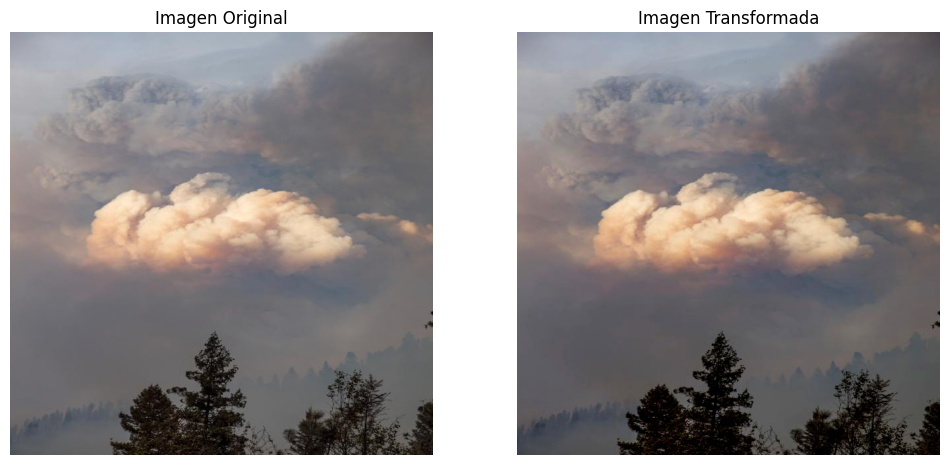

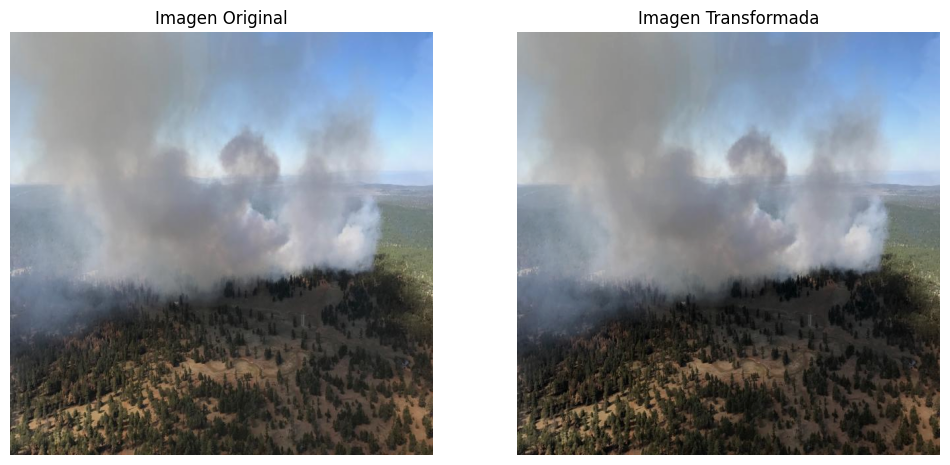

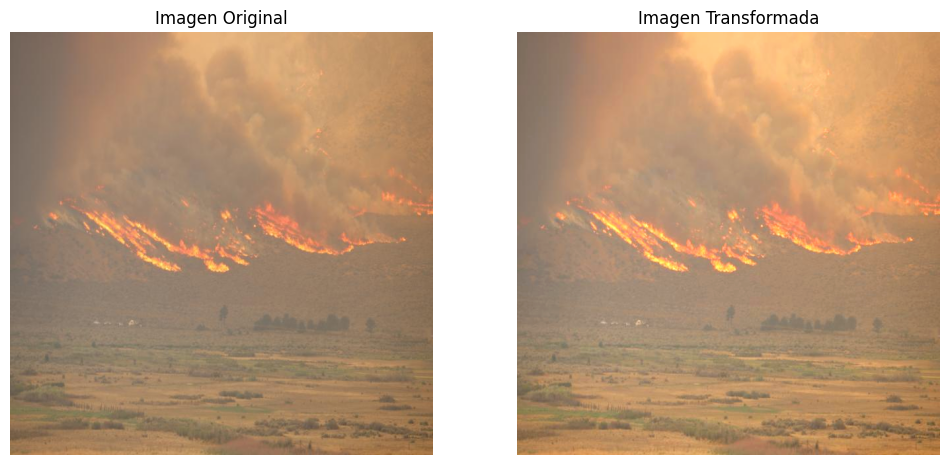

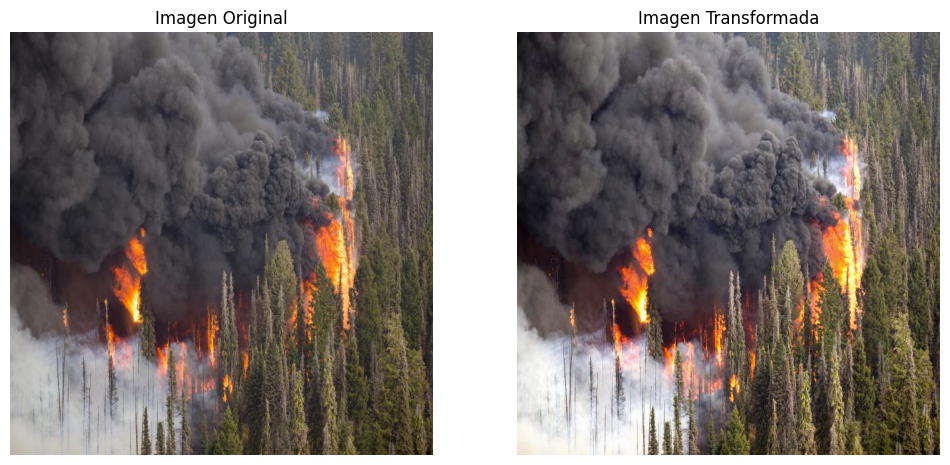

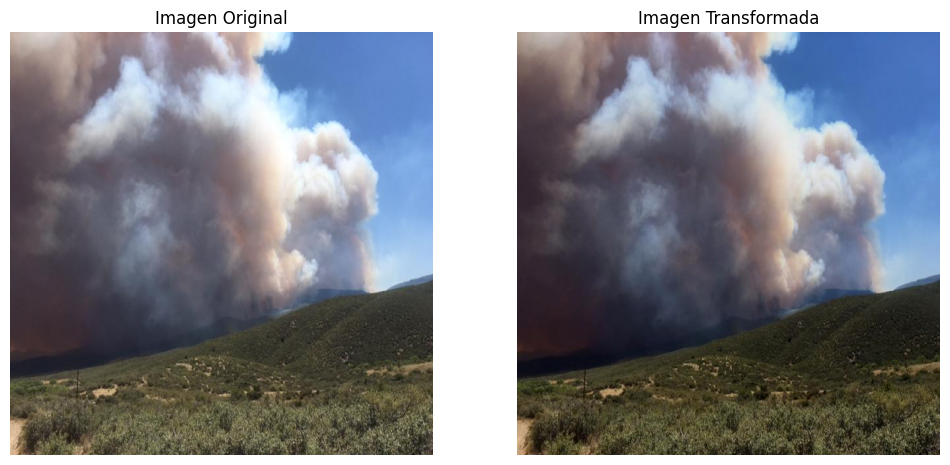

In [ ]:
n_samples = 5

random_samples = random.sample(dataset_train_dicts, n_samples)

for sample in random_samples:
    # Cargar imagen original
    image_path = sample['file_name']
    original_image = read_image(image_path, format="BGR")

    # Convertir la imagen de BGR a RGB para visualización
    original_image_rgb = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)

    # Aplicar transformaciones (Mapper se encarga de aplicar las augmentations)
    transformed = mapperV(sample)  # Esta es la imagen transformada

    # Extraer la imagen transformada (y/o los datos asociados)
    transformed_image = transformed['image'].numpy().transpose(1, 2, 0)  # Convertir de tensor a formato de imagen

    # Convertir la imagen transformada de BGR a RGB (si es necesario)
    transformed_image_rgb = cv.cvtColor(transformed_image, cv.COLOR_BGR2RGB)

    # Visualizar la imagen original y la transformada
    visualize_images(original_image_rgb, transformed_image_rgb)


#### Entrenamiento

Realizamos varios entrenamientos exploratorios variando parámetros del modelo.  

Dejamos aquí enumeradas las últimas tres alternativas que evaluaremos comparativamente luego, con las que logramos mejores resultados.

##### Ejecución 1

Entrenamiento con el pipeline de augmentations durante 50 épocas.

In [ ]:
trainer = CocoTrainer_wAugs(cfg)


[12/06 12:54:34 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

###### Guardar modelo

Guardamos registro del modelo entrenado para luego hacer el análisis comparativo.

In [ ]:
checkpoint_name = '50e_wAug'
checkpoint_path = f"/content/checkpoint_{checkpoint_name}"
os.makedirs(checkpoint_path, exist_ok=True)

origin_path = Path(cfg.OUTPUT_DIR).resolve()

# Copiar estado actual
shutil.copytree(origin_path, checkpoint_path, dirs_exist_ok=True)

# Guardar configuración
with open(os.path.join(checkpoint_path, "configuration.yaml"), "w") as f:
    yaml.dump(cfg.dump(), f)
    f.close()

readme_path = os.path.join(checkpoint_path, 'README.txt')

# Contenido del checkpoint
readme_content = """
# Checkpoint
50 EPOCAS
con transformaciones
"""
# Crear el archivo README y escribir el contenido
with open(readme_path, 'w') as f:
    f.write(readme_content)

# Zip del experimento para descargar y guardar
zip_path = f'/content/checkpoint_{checkpoint_name}.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', checkpoint_path)

print(f"Checkpoint guardado.")

##### Ejecución 2

Entrenamiento sin el pipeline de augmentations durante 50 épocas.

In [ ]:
trainer = CocoTrainer(cfg)

[12/06 12:56:01 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

###### Guardar modelo

Guardamos registro del modelo entrenado para luego hacer el análisis comparativo.

In [ ]:
checkpoint_name = '50e'
checkpoint_path = f"/content/checkpoint_{checkpoint_name}"
os.makedirs(checkpoint_path, exist_ok=True)

origin_path = Path(cfg.OUTPUT_DIR).resolve()

# Copiar estado actual
shutil.copytree(origin_path, checkpoint_path, dirs_exist_ok=True)

# Guardar configuración
with open(os.path.join(checkpoint_path, "configuration.yaml"), "w") as f:
    yaml.dump(cfg.dump(), f)
    f.close()

readme_path = os.path.join(checkpoint_path, 'README.txt')

# Contenido del checkpoint
readme_content = """
# Checkpoint
50 EPOCAS
SIN transformaciones
"""
# Crear el archivo README y escribir el contenido
with open(readme_path, 'w') as f:
    f.write(readme_content)

# Zip del experimento para descargar y guardar
zip_path = f'/content/checkpoint_{checkpoint_name}.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', checkpoint_path)

print(f"Checkpoint guardado.")

Checkpoint guardado.


##### Ejecución 3

Entrenamiento con el pipeline de augmentations durante mayor cantidad de épocas (100).

In [ ]:
n_epochs = 100
cfg.SOLVER.MAX_ITER = (len(dataset_train_dicts)//cfg.SOLVER.IMS_PER_BATCH)*n_epochs # Número máximo de iteraciones (pasos) de entrenamiento.
print(cfg.SOLVER.MAX_ITER)

15500


In [ ]:
trainer = CocoTrainer_wAugs(cfg)

[12/06 02:06:12 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

[12/06 02:06:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl ...


model_final_bfca0b.pkl: 152MB [00:01, 84.2MB/s]                          
head.cls_score.{bias, weight}
  pixel_mean
  pixel_std


[12/06 02:06:18 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[12/06 02:06:32 d2.utils.events]:  eta: 1:54:09  iter: 19  total_loss: 2.41  loss_cls: 1.559  loss_box_reg: 0.8804    time: 0.5566  last_time: 0.4637  data_time: 0.0419  last_data_time: 0.0603   lr: 1.9981e-05  max_mem: 1532M
[12/06 02:06:44 d2.utils.events]:  eta: 1:49:03  iter: 39  total_loss: 1.871  loss_cls: 1.213  loss_box_reg: 0.6395    time: 0.4886  last_time: 0.4043  data_time: 0.0205  last_data_time: 0.0218   lr: 3.9961e-05  max_mem: 1534M
[12/06 02:06:52 d2.utils.events]:  eta: 1:45:23  iter: 59  total_loss: 1.484  loss_cls: 0.9474  loss_box_reg: 0.5126    time: 0.4623  last_time: 0.4413  data_time: 0.0185  last_data_time: 0.0267   lr: 5.9941e-05  max_mem: 1534M
[12/06 02:07:01 d2.utils.events]:  eta: 1:45:15  iter: 79  total_loss: 1.496  loss_cls: 0.906  loss_box_reg: 0.5936    time: 0.4518  last_time: 0.4013  data_time: 0.0212  last_data_time: 0.0094   lr: 7.9921e-05  max_mem: 1535M
[12/06 02:07:09 d2.utils.events]:  eta: 1:45:44  iter: 99  total_loss: 1.353  loss_cls: 0.79

###### Guardar modelo

Guardamos registro del modelo entrenado para luego hacer el análisis comparativo.

In [ ]:
checkpoint_name = '100e_wAug'
checkpoint_path = f"/content/checkpoint_{checkpoint_name}"
os.makedirs(checkpoint_path, exist_ok=True)

origin_path = Path(cfg.OUTPUT_DIR).resolve()

# Copiar estado actual
shutil.copytree(origin_path, checkpoint_path, dirs_exist_ok=True)

# Guardar configuración
with open(os.path.join(checkpoint_path, "configuration.yaml"), "w") as f:
    yaml.dump(cfg.dump(), f)
    f.close()

readme_path = os.path.join(checkpoint_path, 'README.txt')

# Contenido del checkpoint
readme_content = """
# Checkpoint
100 EPOCAS
con transformaciones
"""
# Crear el archivo README y escribir el contenido
with open(readme_path, 'w') as f:
    f.write(readme_content)

# Zip del experimento para descargar y guardar
zip_path = f'/content/checkpoint_{checkpoint_name}.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', checkpoint_path)

print(f"Checkpoint guardado.")

Checkpoint guardado.
